# Simple Custom convnet


## Setup

In [1]:
import numpy as np
import sys
from tensorflow import keras
from tensorflow.keras import layers
import sklearn.model_selection
import matplotlib.pyplot as plt

## Load model


In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load model from path
file_name = 'smiley_cnn_acc_1.0'
path = f'/content/drive/MyDrive/Workspace/dissertation/{file_name}.h5'
model = keras.models.load_model(path)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 2)           8         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 2)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


## Show filters


(2, 2, 1, 2)
[[[-0.9578335   0.70368326]
  [-0.954979   -0.7249028 ]]

 [[-0.47843927 -0.70245713]
  [-0.47832325 -0.9536416 ]]]
[[-0.9578335  -0.954979  ]
 [-0.47843927 -0.47832325]]


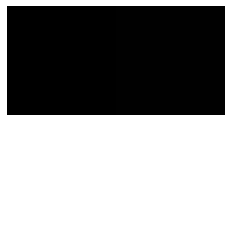

[[ 0.70368326 -0.7249028 ]
 [-0.70245713 -0.9536416 ]]


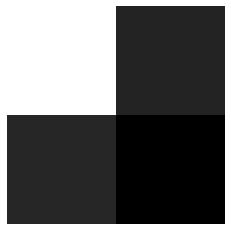

In [40]:
filters = model.layers[0].get_weights()[0]
print (filters.shape)
filters.shape = (2, 2, 2)
print(filters)
print("================")

for i in range (filters.shape[-1]):
  filter = filters[:,:,i]
  print(filter)
  plt.imshow(filter, cmap='gray')
  plt.axis('off')
  plt.show()

## Convert convolutional layer to IML (quantised)

In [4]:
weights = model.layers[0].get_weights()[0]
print(f'layer 0 weights shape: {weights.shape}')

layer 0 weights shape: (2, 2, 1, 2)


In [6]:
import math

def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return int(math.floor(n*multiplier + 0.5) / multiplier)

def print_rounded_weights(weights, layer_id):
  print(f'layer{layer_id} = [')
  for l in range (weights.shape[3]):
    print('\t[')
    for k in range (weights.shape[2]):
      print('\t\t[ ', end='')
      for i in range (weights.shape[0]):
        print('\t\t\t[ ', end='')
        for j in range (weights.shape[1]):
          end = '' if j == weights.shape[1] - 1 else '; '
          print('{0:d}'.format(round_half_up(weights[i][j][k][l])), end=end)
        print('];', end='')
      print('\t\t];')
    print('\t];')
  print(']')

print_rounded_weights(weights, 0)

layer0 = [
	[
		[ 			[ 0; 0];			[ -1; -1];		];
	];
	[
		[ 			[ 0; 0];			[ 0; 1];		];
	];
]


## Convert FC layer to IML

In [8]:
weights = model.layers[4].get_weights()[0]
biases = model.layers[4].get_weights()[1]

def print_rounded_weights_fc(weights, biases, layer_id):
  print(f'layer{layer_id} = [')
  for i in range (weights.shape[1]):
    print('\t[{0:d}; '.format(round_half_up(biases[i])), end='')
    for j in range (weights.shape[0]):
      print('{0:d}; '.format(round_half_up(weights[j][i])), end='')
    print('];')
  print(']')

print_rounded_weights_fc(weights, biases, 4)

layer4 = [
	[0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; ];
	[0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 1; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; -1; 0; -1; 1; 0; ];
]


## Print weights to file

In [9]:
# set stdout to a file
filename='weights_quantised.iml'
stdout_fileno = sys.stdout
sys.stdout = open(filename, 'w')

print("module Weights = struct")

weights = model.layers[0].get_weights()[0]
print_rounded_weights(weights, 0)

weights = model.layers[4].get_weights()[0]
biases = model.layers[4].get_weights()[1]
print_rounded_weights_fc(weights, biases, 4)

print("end")

# Close the file
sys.stdout.close()
# Restore sys.stdout to our old saved file handler
sys.stdout = stdout_fileno

### Evaluate quantised model

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split

from random import randint

def blank(height=9, width=9):
    return [[0. for x in range(width)] for y in range(height)]

def bound(x, l=0, h=10):
    if x < l:
        return l
    if x > h:
        return h
    return x

def draw_feature(canvas, feature, origin=(0,0)):
  (x0, y0) = origin
  for (x, y) in feature:
      canvas[x0 + x][y0 + y] = 1.

def draw_face(eyes, mouth, noise):
  canvas = blank()
  #draw eyes
  draw_feature(canvas, eyes)
  draw_feature(canvas, mouth)
  draw_feature(canvas, noise)
  return canvas


def print_face(face):
    for line in face:
        for x in line:
            print ('X' if x == 1.0 else '.', end='')
        print('')
    print('')


def make_data(noise=False):
  x_train = np.ndarray(shape=(0,))
  y_train = np.ndarray(shape=(0,))

  eyes_variants = [
      [(2, 2), (2, 6)],
      [(2, 1), (2, 7)],
      [(2, 1), (2, 5)],
      [(2, 2), (2, 7)]
  ]

  noise_variants = [
      [],
      [(0, 0)],
      [(0, 8)]
  ]

  happy_mouths = [
      [(4, 1), (5, 2), (6, 3), (6, 4),(6, 5),(5, 6),(4, 7)],
      [(5, 1), (6, 2), (7, 3), (7, 4),(7, 5),(6, 6),(5, 7)],

      [(4, 1), (5, 2), (5, 3), (5, 4),(5, 5),(5, 6),(4, 7)],
      [(5, 1), (6, 2), (6, 3), (6, 4),(6, 5),(6, 6),(5, 7)],

      [(5, 2), (6, 3), (6, 4),(6, 5),(5, 6)],
      [(6, 2), (7, 3), (7, 4),(7, 5),(6, 6)],
  ]

  sad_mouths = [
      [(5, 1), (4, 2), (4, 3), (4, 4),(4, 5),(4, 6),(5, 7)],
      [(6, 1), (5, 2), (5, 3), (5, 4),(5, 5),(5, 6),(6, 7)],

      [(6, 1), (5, 2), (4, 3), (4, 4),(4, 5),(5, 6),(6, 7)],
      [(7, 1), (6, 2), (5, 3), (5, 4),(5, 5),(6, 6),(7, 7)],

      [(5, 2), (4, 3), (4, 4),(4, 5),(5, 6)],
      [(6, 2), (5, 3), (5, 4),(5, 5),(6, 6)],
  ]
  
  for noise in noise_variants:
    for mouth in happy_mouths:
      for eyes in eyes_variants:
        #   if noise:
        #     noise = noise_variants[randint(0, len(noise_variants - 1))]
        #   else: 
        #     noise = []
        face = draw_face(eyes, mouth, noise)
        face = np.array(face)
        face.shape = (1, 9, 9, 1)
        x_train = np.concatenate((x_train, face), axis=0) if x_train.size else face
        y_train = np.append(y_train, 0)
    for mouth in sad_mouths:
      for eyes in eyes_variants:
        #   if noise:
        #     noise = noise_variants[randint(0, len(noise_variants - 1))]
        #   else: 
        #     noise = []
        face = draw_face(eyes, mouth, noise)
        face = np.array(face)
        face.shape = (1, 9, 9, 1)
        x_train = np.concatenate((x_train, face), axis=0) if x_train.size else face
        y_train = np.append(y_train, 1)

  x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=0)

  return (x_train, y_train), (x_test, y_test)

# Model / data parameters
num_classes = 2
input_shape = (9, 9, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = make_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (108, 9, 9, 1)
108 train samples
36 test samples


In [47]:

weights = model.layers[0].get_weights()[0]
rounded_weights = np.around(weights)
model.layers[0].set_weights([rounded_weights])

weights = model.layers[4].get_weights()[0]
biases = model.layers[4].get_weights()[1]
rounded_weights = np.around(weights)
print(rounded_weights.shape)
rounded_biases = np.around(biases)
model.layers[4].set_weights([rounded_weights, rounded_biases])

(32, 2)


In [48]:

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2915412187576294
Test accuracy: 1.0
